# Setting up

In [1]:
# activate inline plotting
%matplotlib inline
from setup import *

In [2]:
if 0:
    file_name = './../data/arab107/atwell_107.hdf5'
    geno_reader  = gr.genotype_reader_tables(file_name)
    pheno_reader = phr.pheno_reader_tables(file_name)

    #the data object allows to query specific genotype or phenotype data
    dataset = data.QTLData(geno_reader=geno_reader,pheno_reader=pheno_reader)



In [3]:
if 1:
    #the data used in this study have been pre-converted into an hdf5 file. 
    #to preprocess your own data, please use limix command line tool
    file_name = './../data/BYxRM/BYxRM.hdf5'
    geno_reader  = gr.genotype_reader_tables(file_name)
    pheno_reader = phr.pheno_reader_tables(file_name)
    
    #the data object allows to query specific genotype or phenotype data
    dataset = data.QTLData(geno_reader=geno_reader,pheno_reader=pheno_reader)


<matplotlib.colorbar.Colorbar instance at 0x10a24b758>

/Users/davis/anaconda/envs/py2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


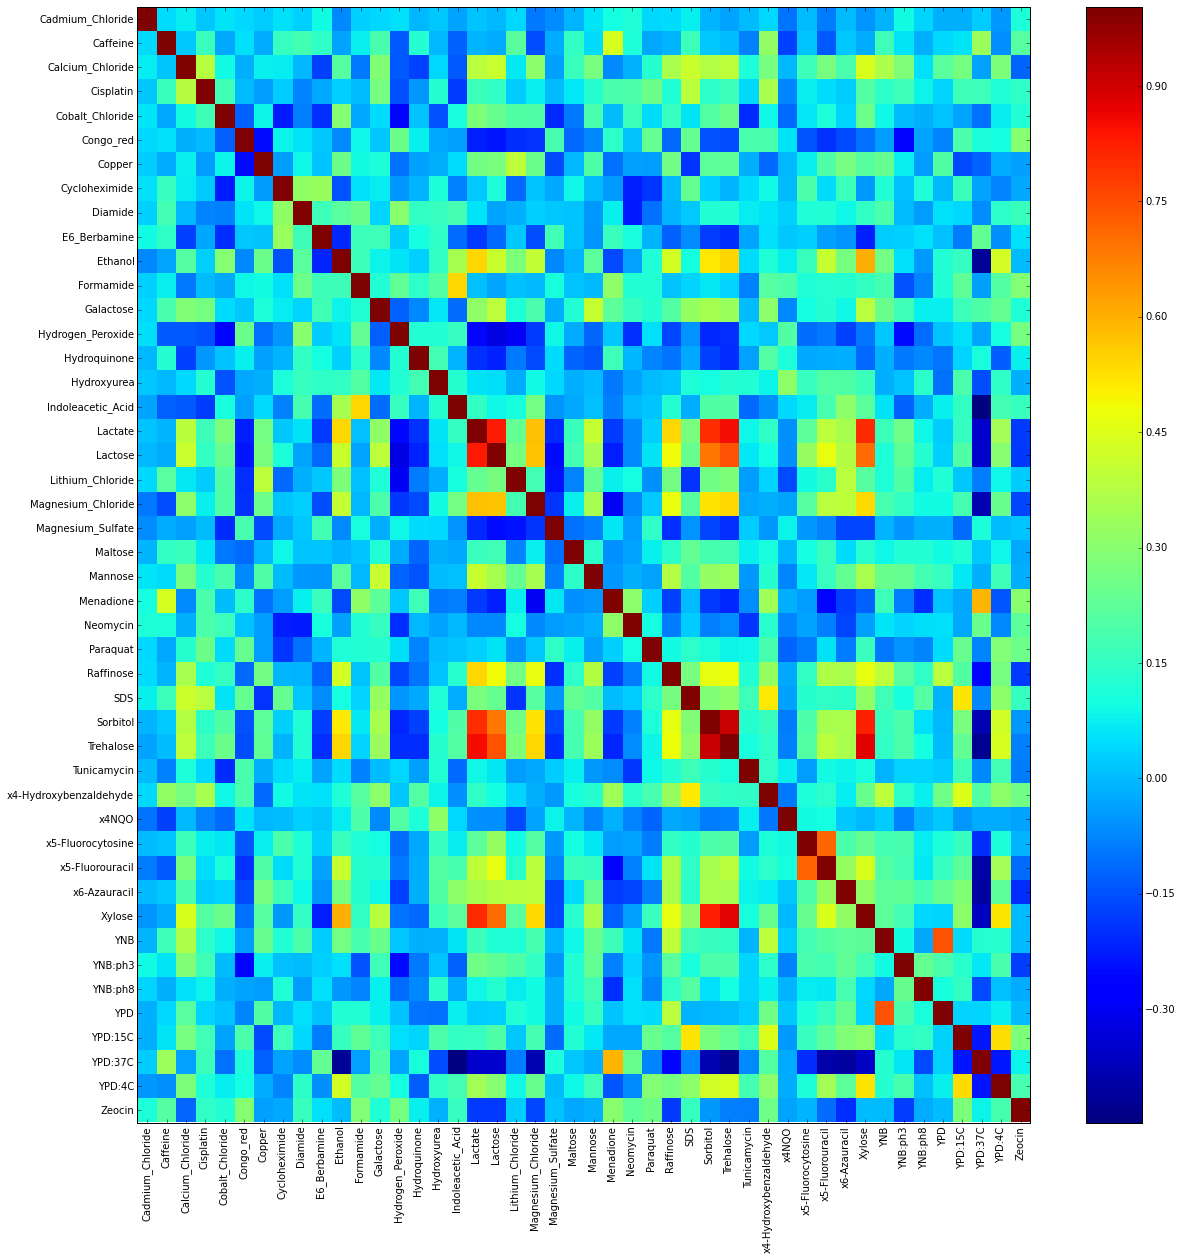

In [4]:
#choosing which phentoypes to model jointly ?
phenotypes,sample_idx = dataset.getPhenotypes(intersection=True)
phenotype_names = dataset.phenotype_ID

pl.figure(figsize=[20,20])
Ce= sp.cov(phenotypes.values.T)
pl.imshow(Ce,aspect='auto',interpolation='none')
pl.xticks(sp.arange(len(phenotype_names)),phenotype_names,rotation=90)
pl.yticks(sp.arange(len(phenotype_names)),phenotype_names,rotation=0)
pl.colorbar()




In [5]:
#select subset of phenotypes

#flowering phenotypes (A. thaliana data)
phenotype_names = ['5_FT10','6_FT16','7_FT22']

#a larger set of correlated and anti correlated traits:
#phenotype_names = ['Ethanol','Congo_red','Galactose']
#YPD, different temperatures:
phenotype_names = ['YPD:37C','YPD:15C','YPD:4C']

phenotype_query = "(phenotype_ID in %s)" %  str(phenotype_names)

data_subsample = dataset.subsample_phenotypes(phenotype_query=phenotype_query,
                                           intersection=True)

sample_relatedness_unnormalized = data_subsample.getCovariance(normalize=True,center=True)

sample_relatedness  = sample_relatedness_unnormalized/ \
    sample_relatedness_unnormalized.diagonal().mean()

if 1:
    #subsample for speed?
    Is = sp.arange(dataset.geno_pos.shape[0])
    #take every 10th SNP
    Is = Is[::10]
    data_subsample = data_subsample.subsample(cols_geno = Is)
    
#get variables we need from data
snps = data_subsample.getGenotypes(center=False,unit=False)
position = data_subsample.getPos()
position,chromBounds = data_util.estCumPos(position=position,offset=100000)

phenotypes,sample_idx = data_subsample.getPhenotypes(phenotype_query=phenotype_query,
                                                     intersection=True) 
phenotype_std = preprocess.rankStandardizeNormal(phenotypes.values)

N = snps.shape[0]
S = snps.shape[1]
P = phenotypes.shape[1]
print "loaded %d samples, %d phenotypes, %s snps" % (N,P,S)

loaded 804 samples, 3 phenotypes, 1163 snps


/Users/davis/anaconda/envs/py2.7/lib/python2.7/site-packages/limix/io/phenotype_reader.py:133: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1008 but corresponding boolean dimension is 804
  phenotypes = pd.DataFrame(data=phenotypes, index=self.sample_ID[sample_idx_intersect],columns=self.phenotype_ID[I])


In [6]:
#preprocess phenotypes using boxcox
if 0:
    phenotype_vals_boxcox, maxlog = preprocess.boxcox(phenotypes.values)
    phenotype_vals_boxcox -= phenotype_vals_boxcox.mean(axis=0)
    phenotype_vals_boxcox /= phenotype_vals_boxcox.std(axis=0)
    phenotypes.ix[:,:] = phenotype_vals_boxcox

# Correlation between phenotypes
* We start by examining the correlation between phenotypes

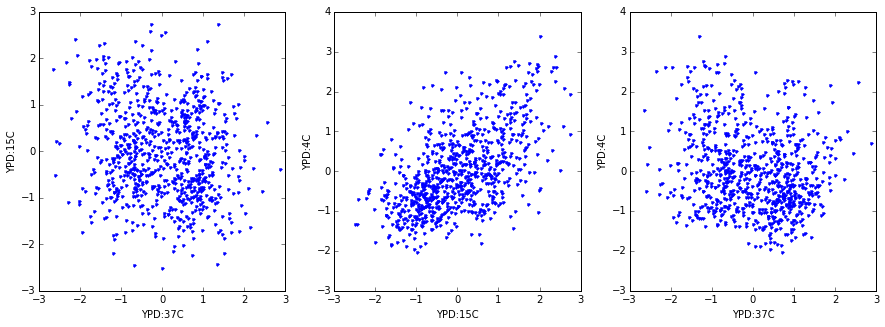

In [7]:
#pairwise corrrelations of the first 3 traits
pl.figure(figsize=[15,5])
pl.subplot(1,3,1)
pl.plot(phenotypes[phenotype_names[0]].values,phenotypes[phenotype_names[1]].values,'.')
pl.xlabel(phenotype_names[0])
pl.ylabel(phenotype_names[1])

pl.subplot(1,3,2)
pl.plot(phenotypes[phenotype_names[1]].values,phenotypes[phenotype_names[2]].values,'.')
pl.xlabel(phenotype_names[1])
pl.ylabel(phenotype_names[2])

pl.subplot(1,3,3)
pl.plot(phenotypes[phenotype_names[0]].values,phenotypes[phenotype_names[2]].values,'.')
pl.xlabel(phenotype_names[0])
pl.ylabel(phenotype_names[2])


In [8]:
Ce = sp.corrcoef(phenotypes.T)

sample_relatedness = data_subsample.getCovariance()
#set parameters for the analysis
N, G = phenotypes.shape 
# variance component model
vc = var.VarianceDecomposition(phenotypes.values)
vc.addFixedEffect()
vc.addRandomEffect(K=sample_relatedness,trait_covar_type='freeform')
vc.addRandomEffect(is_noise=True,trait_covar_type='freeform')
vc.optimize()
# retrieve geno and noise covariance matrix
Cg = vc.getTraitCovar(0)
Cn = vc.getTraitCovar(1)

<matplotlib.colorbar.Colorbar instance at 0x118762ab8>

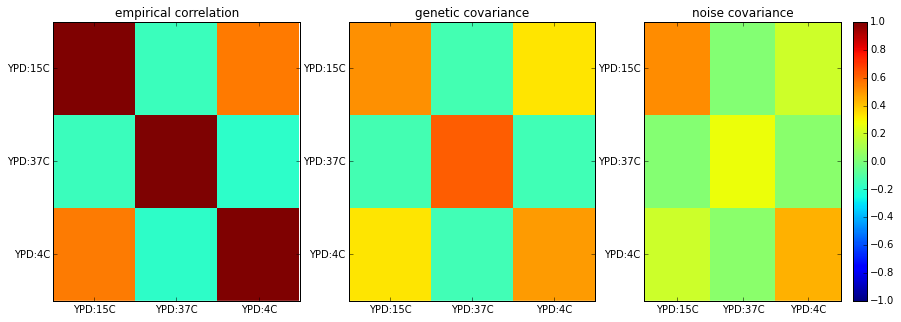

In [9]:
pl.figure(figsize=[15,5])
pl.subplot(1,3,1)
pl.imshow(Ce,aspect='auto',interpolation='none',vmin=-1,vmax=1)
pl.xticks(sp.arange(len(phenotype_names)),phenotypes.columns)
pl.yticks(sp.arange(len(phenotype_names)),phenotypes.columns)
pl.title('empirical correlation')

pl.subplot(1,3,2)
pl.imshow(Cg,aspect='auto',interpolation='none',vmin=-1,vmax=1)
pl.xticks(sp.arange(len(phenotype_names)),phenotypes.columns)
pl.yticks(sp.arange(len(phenotype_names)),phenotypes.columns)
pl.title('genetic covariance')


pl.subplot(1,3,3)
pl.imshow(Cn,aspect='auto',interpolation='none',vmin=-1,vmax=1)
pl.xticks(sp.arange(len(phenotype_names)),phenotypes.columns)
pl.yticks(sp.arange(len(phenotype_names)),phenotypes.columns)
pl.title('noise covariance')
pl.colorbar()



In [10]:
#convert P-values to a DataFrame for nice output writing:
lmm = qtl.test_lmm(snps=snps[sample_idx],pheno=phenotypes.values,K=sample_relatedness)
#convert P-values to a DataFrame for nice output writing:
pvalues_lmm = pd.DataFrame(data=lmm.getPv().T,index=data_subsample.geno_ID,
                       columns=phenotype_names)

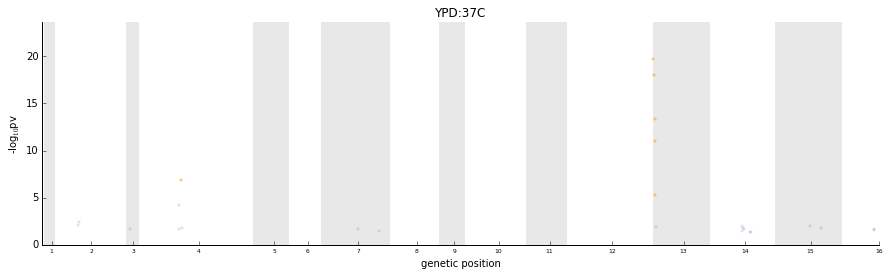

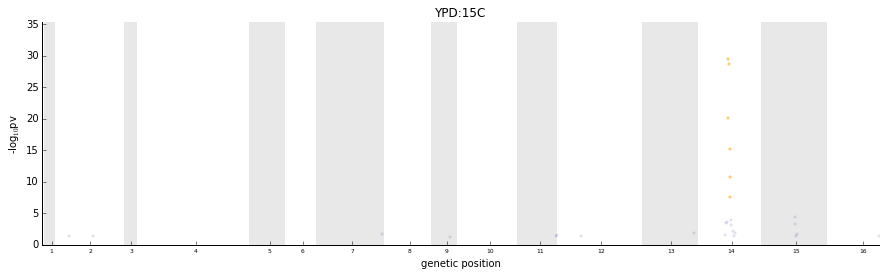

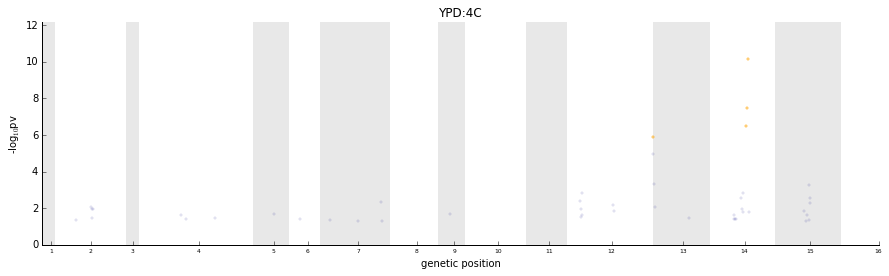

In [11]:
# Genome-wide manhatton plots for one phenotype:
for p_ID in phenotype_names:
    pl.figure(figsize=[15,4])
    plot_manhattan(posCum=position['pos_cum'],pv=pvalues_lmm[p_ID].values,chromBounds=chromBounds,thr_plotting=0.05)
    pl.title(p_ID)

# Any-effect test

In [12]:
P = phenotypes.values.shape[1]

covs = None                 #covariates
Acovs = None                #the design matrix for the covariates   
Asnps = sp.eye(P)           #the design matrix for the SNPs
K1r = sample_relatedness    #the first sample-sample covariance matrix (non-noise)
K2r = sp.eye(N)             #the second sample-sample covariance matrix (noise)
K1c = None                  #the first phenotype-phenotype covariance matrix (non-noise)
K2c = None                  #the second phenotype-phenotype covariance matrix (noise)
covar_type = 'freeform'     #the type of the trait/trait covariance to be estimated 
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

# Running the analysis
# when cov are not set (None), LIMIX considers an intercept (covs=SP.ones((N,1)))
lmm, pvalues = qtl.test_lmm_kronecker(snps=snps[sample_idx],phenos=phenotypes.values,covs=covs,Acovs=Acovs,
                                      Asnps=Asnps,K1r=K1r,trait_covar_type=covar_type)

#convert P-values to a DataFrame for nice output writing:
pvalues = pd.DataFrame(data=pvalues.T,index=data_subsample.geno_ID,columns=['multi_trait'])

.. Training the backgrond covariance with a GP model
Background model trained in 4.35 s


/Users/davis/anaconda/envs/py2.7/lib/python2.7/site-packages/limix/modules/qtl.py:262: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if K1r==None:


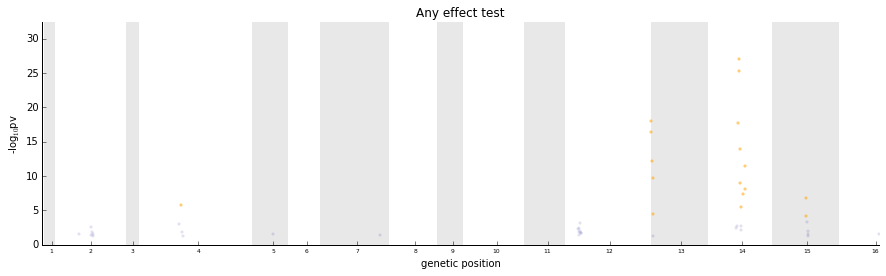

In [14]:
pl.figure(figsize=[15,4])
thr = 0.1/snps.shape[1]
plot_manhattan(posCum=position['pos_cum'],thr=thr,pv=pvalues['multi_trait'].values,chromBounds=chromBounds,thr_plotting=0.05)
pl.title('Any effect test')



# Testing for common effects

A common effect test is a 1 degree of freedom test and can be done by setting
\begin{equation}
\mathbf{A}_1^\text{(snp)} = \mathbf{1}_{1,P},\;\;\;
\mathbf{A}_0^\text{(snp)} = \mathbf{0}
\end{equation}

In [13]:
P = phenotypes.values.shape[1]

covs = None                 #covariates
Acovs = None                #the design matrix for the covariates   
Asnps = sp.ones((1,P))           #the design matrix for the SNPs
K1r = sample_relatedness    #the first sample-sample covariance matrix (non-noise)
K2r = sp.eye(N)             #the second sample-sample covariance matrix (noise)
K1c = None                  #the first phenotype-phenotype covariance matrix (non-noise)
K2c = None                  #the second phenotype-phenotype covariance matrix (noise)
covar_type = 'freeform'     #the type of the trait/trait covariance to be estimated 
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

# Running the analysis
# when cov are not set (None), LIMIX considers an intercept (covs=SP.ones((N,1)))
lmm, pvalues_common = qtl.test_lmm_kronecker(snps=snps[sample_idx],phenos=phenotypes.values,covs=covs,Acovs=Acovs,
                                      Asnps=Asnps,K1r=K1r,trait_covar_type=covar_type)

#convert P-values to a DataFrame for nice output writing:
pvalues_common = pd.DataFrame(data=pvalues_common.T,index=data_subsample.geno_ID,columns=['common'])

.. Training the backgrond covariance with a GP model
Background model trained in 4.37 s


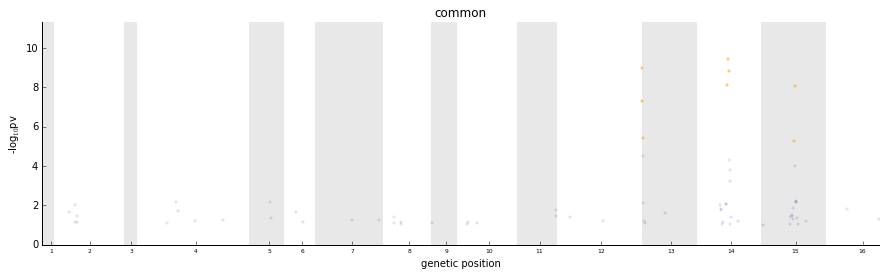

In [15]:
pl.figure(figsize=[15,4])
plot_manhattan(posCum=position['pos_cum'],pv=pvalues_common['common'].values,chromBounds=chromBounds,thr_plotting=0.1)
pl.title('common')

# Testing for GxE (specific effect test)

For a specifc effect test for trait $p$
the alternative model is set to have both a common and a specific effect
for trait $p$ from the SNP while the null model has only a common effect.

It is a 1 degree of freedom test and,
in the particular case of $P=3$ traits and for $p=0$, it can be done by setting
\begin{equation}
\mathbf{A}_1^\text{(snp)} =
\begin{pmatrix}
  1 & 0 & 0 \\
  1 & 1 & 1
 \end{pmatrix}
\;\;\;,
\mathbf{A}_0^\text{(snp)} = \mathbf{1}_{1,3}
\end{equation}

In [16]:
Asnps0 = sp.ones((1,P))     #the null model design matrix for the SNPs
Asnps1 = sp.zeros((2,P))    #the alternative model design matrix for the SNPs
Asnps1[0,:] = 1.0       
Asnps1[1,0] = 1.0  

# Running the analysis
# when cov are not set (None), LIMIX considers an intercept (covs=SP.ones((N,1)))
pvalues_inter = qtl.test_interaction_lmm_kronecker(snps=snps[sample_idx],phenos=phenotypes.values,covs=covs,Acovs=Acovs,
                                      Asnps0=Asnps0,Asnps1=Asnps1,K1r=K1r,trait_covar_type=covar_type)

print "Design(0): \n"+str(Asnps0)
print "Design(Alt): \n"+str(Asnps1)


#convert P-values to a DataFrame for nice output writing:
pvalues_inter = pd.DataFrame(data=sp.concatenate(pvalues_inter).T,index=data_subsample.geno_ID,
                       columns=["specific","null_common","alternative_any"])

.. Training the backgrond covariance with a GP model
Background model trained in 4.33 s
Design(0): 
[[ 1.  1.  1.]]
Design(Alt): 
[[ 1.  1.  1.]
 [ 1.  0.  0.]]


/Users/davis/anaconda/envs/py2.7/lib/python2.7/site-packages/limix/modules/qtl.py:373: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if K1r==None:


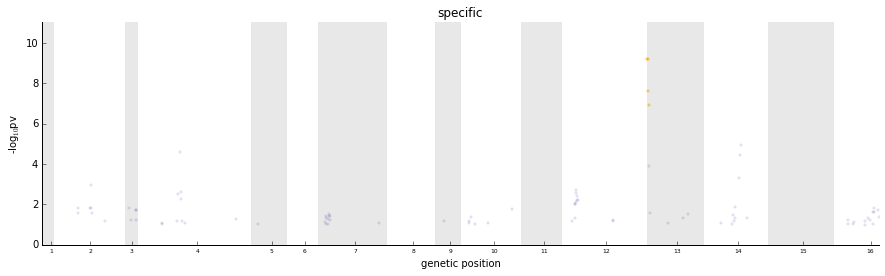

In [17]:
pl.figure(figsize=[15,4])
plot_manhattan(posCum=position['pos_cum'],pv=pvalues_inter['specific'].values,chromBounds=chromBounds,thr_plotting=0.1)
pl.title('specific')

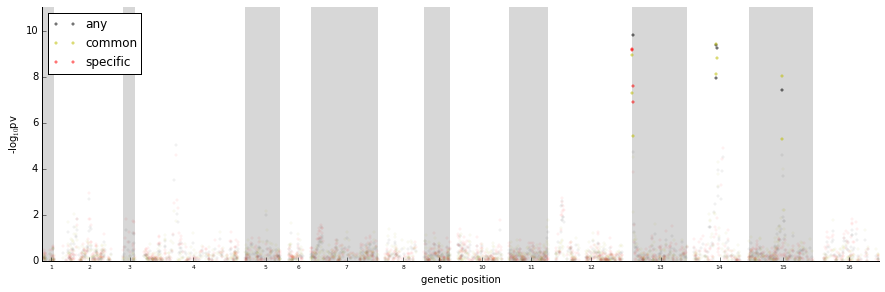

In [18]:
tests = ['Any effect test','Interaction effect test']
pl.figure(figsize=[15,10])

#lim = -1.2*sp.log10(SP.array([pvalues['alternative_any'].min(),
#        pvalues_inter['null_common'].min(),pvalues_inter['specific'].min()]).min())
plt = pl.subplot(2,1,1)
plot_manhattan(position['pos_cum'],pvalues_inter['alternative_any'],
               chromBounds,colorS='k',colorNS='k',alphaNS=0.05,labelS='any')
plot_manhattan(position['pos_cum'],pvalues_inter['null_common'],
               chromBounds,colorS='y',colorNS='y',alphaNS=0.05,labelS='common')
plot_manhattan(position['pos_cum'],pvalues_inter['specific'],
               chromBounds,colorS='r',colorNS='r',alphaNS=0.05,labelS='specific')
pl.legend(loc='upper left')
